In [2]:
# Step 1: Import Libraries and Load Model
import os
import librosa
import torch
import torchaudio
import numpy as np
import pandas as pd
import re
from difflib import SequenceMatcher

from transformers import WhisperTokenizer, WhisperProcessor, WhisperFeatureExtractor, WhisperForConditionalGeneration

c:\Users\mdnah\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load the two transcription CSV files
dementia_df = pd.read_csv(r"C:\Users\mdnah\OneDrive\Desktop\TextClassification\Sentence Data - Dementia.csv")
non_dementia_df = pd.read_csv(r"C:\Users\mdnah\OneDrive\Desktop\TextClassification\Sentence Data - Non_Dementia.csv")

# Prefix the labels to avoid conflicts
dementia_df['label'] = 'D_' + dementia_df['label'].astype(str)
non_dementia_df['label'] = 'ND_' + non_dementia_df['label'].astype(str)

# Merge the two dataframes
merged_df = pd.concat([dementia_df, non_dementia_df], ignore_index=True)

# Save the merged dataframe to a new CSV file
merged_df.to_csv(r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Merged_Dataset.csv', index=False, encoding='utf-8-sig')

print("Merged file saved successfully.")

print(merged_df.head(40))

Merged file saved successfully.
    label                                    sentences     class Unnamed: 3  \
0    D_s1             আমি খাবার কোথাও খুঁজে পাচ্ছি না।  Dementia        NaN   
1    D_s2             আমি কি খেয়েছি মনে করতে পারছি না।  Dementia        NaN   
2    D_s3            কোথায় খাবারটা রাখা হয়েছে মনে নেই।  Dementia        NaN   
3    D_s4                 আজকের রান্নাটা মজাদার হয়েছে।  Dementia        NaN   
4    D_s5                পানির গ্লাসটা একটু এগিয়ে দাও।  Dementia        NaN   
5    D_s6                    আমার ইলিশ মাছ অনেক পছন্দ।  Dementia        NaN   
6    D_s7                  মুরগির ডিমটা সিদ্ধ করে আনো।  Dementia        NaN   
7    D_s8  আমার রুটি দিয়ে হাঁসের মাংস খেতে ইচ্ছা করছে।  Dementia        NaN   
8    D_s9               খাওয়ার পর একটু হাটাহাটি দরকার।  Dementia        NaN   
9   D_s10                         আমার এখন ক্ষুধা নেই।  Dementia        NaN   
10  D_s11                  ভাত খেতে ইচ্ছা করছে না এখন।  Dementia        NaN   
11  D_s12           

In [4]:
merged_df['class'].value_counts()

class
Dementia        370
Non_Dementia    370
Name: count, dtype: int64

In [5]:
# Load the merged CSV file
merged_df = pd.read_csv(r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Merged_Dataset.csv')

# Function to remove text after (and including) the first Bangla period (দাঁড়ি)
def clean_sentence(sentence):
    # Split the sentence at the first occurrence of '।' and keep the first part only
    parts = sentence.split('।', 1)
    cleaned_sentence = parts[0] if len(parts) > 1 else sentence
    # Remove commas (,) from the sentence
    return cleaned_sentence.replace(',', '')


# Apply the cleaning function to the transcribed_text column
merged_df['sentences'] = merged_df['sentences'].apply(clean_sentence)

# Save the cleaned dataset to a new CSV file
merged_df.to_csv(r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Merged_Dataset.csv', index=False, encoding='utf-8-sig')

print("Unwanted parts removed successfully. Cleaned file saved.")

merged_df.head(40)

Unwanted parts removed successfully. Cleaned file saved.


,label,sentences,class,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,D_s1,আমি খাবার কোথাও খুঁজে পাচ্ছি না,Dementia,NaN,NaN,NaN
1,D_s2,আমি কি খেয়েছি মনে করতে পারছি না,Dementia,NaN,NaN,NaN
2,D_s3,কোথায় খাবারটা রাখা হয়েছে মনে নেই,Dementia,NaN,NaN,NaN
3,D_s4,আজকের রান্নাটা মজাদার হয়েছে,Dementia,NaN,NaN,NaN
4,D_s5,পানির গ্লাসটা একটু এগিয়ে দাও,Dementia,NaN,NaN,NaN
5,D_s6,আমার ইলিশ মাছ অনেক পছন্দ,Dementia,NaN,NaN,NaN
6,D_s7,মুরগির ডিমটা সিদ্ধ করে আনো,Dementia,NaN,NaN,NaN
7,D_s8,আমার রুটি দিয়ে হাঁসের মাংস খেতে ইচ্ছা করছে,Dementia,NaN,NaN,NaN
8,D_s9,খাওয়ার পর একটু হাটাহাটি দরকার,Dementia,NaN,NaN,NaN
9,D_s10,আমার এখন ক্ষুধা নেই,Dementia,NaN,NaN,NaN


In [6]:
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter

Cleaned dataset saved to: C:\Users\mdnah\OneDrive\Desktop\TextClassification\Cleaned_Dataset.csv


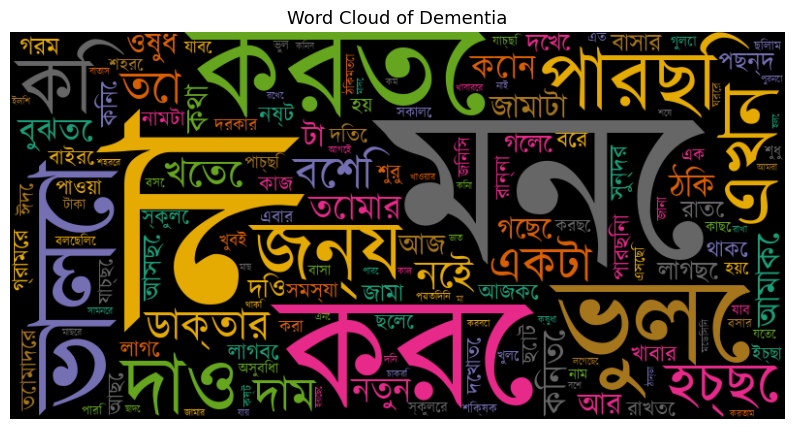

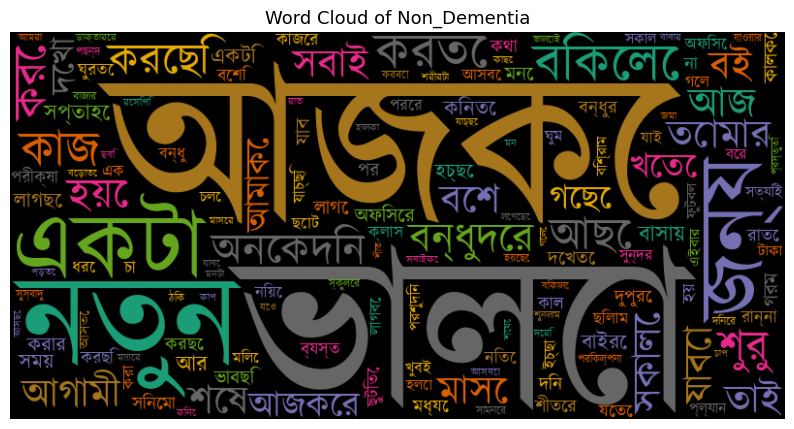

In [7]:
#"আমি", "আমার", "অনেক", "এই", "করে", "হবে", "হতে", "হয়", "করা", "এবং", "তো", "কিন্তু", "যদি", "বা", "হয়নি", "এখন", "আগে", "তাই",
#"আবার", "সব", "কিছু", "তার", "জন্য", "থেকে", "পরে", "দিয়ে", "সঙ্গে", "পর্যন্ত", "দিকে", "মধ্যে", "এর", "আর", "সেখানে", "এখানে", "অথবা", "তারপর", "ও"

bangla_stop_words = ["এবং", "বা", "কিন্তু", "যে", "এটি", "সে", "তার", "তাদের", "আমাদের", "আমি", "তুমি", "তিনি", 
    "তার", "এর", "হতে", "ছিল", "হবে", "হ্যাঁ", "যেমন", "যখন", "যদি", "কোথাও", "এখানে", 
    "সেখানে", "কেন", "তখন", "খুব", "কিছু", "সব", "অনেক", "অধিকাংশ", "কখনও", "তাও", "আমার", 
    "মাঝে", "থেকে", "উপর", "নিচে", "মতো", "একটু", "আবার", "আগে", "পরে", "সাথে", "এই", "ঐ", 
    "যেখানে", "কিভাবে", "কত"
    ]

# Define a preprocessing function
def preprocess_text(sentence, stop_words):
    # Split into words
    words = sentence.split()
    # Remove stop words, single-character fragments, and non-Bangla patterns
    words = [word for word in words if word not in stop_words and len(word) > 1 and re.match(r'^[অ-হা-য়]+$', word)]
    # Join back into a cleaned sentence
    cleaned_sentence = " ".join(words)
    return cleaned_sentence if cleaned_sentence else "EMPTY"  # Replace empty strings with "EMPTY"

# Create a cleaned dataset
cleaned_df = merged_df.copy()
cleaned_df['cleaned_text'] = cleaned_df['sentences'].apply(lambda x: preprocess_text(x, bangla_stop_words))

# Save the cleaned dataframe to a new CSV file
cleaned_file_path = r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Cleaned_Dataset.csv'  # Update the save path
cleaned_df.to_csv(cleaned_file_path, index=False, encoding='utf-8-sig')
print(f"Cleaned dataset saved to: {cleaned_file_path}")

# Generate Word Cloud
def generate_wordcloud(data, title):
    wc = WordCloud(
        font_path=font_path,
        width=800,
        height=400,
        max_words=150,
        colormap="Dark2"
    ).generate_from_frequencies(dict(data.values))
    plt.figure(figsize=(10, 6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Word Cloud of {title}", fontsize=13)
    plt.show()

# Generate Word Clouds by Category
def generate_category_wordclouds(df):
    for category in df['class'].unique():
        word_counts = Counter(" ".join(df[df['class'] == category]['cleaned_text']).split())
        word_count_df = pd.DataFrame(word_counts.most_common(500), columns=['Common_words', 'count'])
        generate_wordcloud(word_count_df, category)

# Parameters
font_path = r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Previous models\kalpurush.ttf'

# Generate Word Clouds
generate_category_wordclouds(cleaned_df)

In [8]:
# Define a custom tokenizer for TF-IDF
def custom_bangla_tokenizer(text):
    return text.split()  # Tokenize by splitting on spaces

# Initialize TF-IDF vectorizer for word-level unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=custom_bangla_tokenizer,  # Custom tokenizer for Bangla
    ngram_range=(1, 3),  # Generate unigrams and bigrams
    max_features=3000  # Limit to top 1000 features
)

# Fit and transform the cleaned text
X_tfidf = tfidf_vectorizer.fit_transform(cleaned_df['cleaned_text'])

# Save the TF-IDF vectorizer for future use
tfidf_vectorizer_path = r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Features\TFIDF_Vectorizer.pkl'
with open(tfidf_vectorizer_path, 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)
print(f"TF-IDF vectorizer saved to: {tfidf_vectorizer_path}")

# Save the TF-IDF matrix for further use
tfidf_matrix_path = r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Features\TFIDF_Features.pkl'
with open(tfidf_matrix_path, 'wb') as f:
    pickle.dump(X_tfidf, f)

# Display some information about the TF-IDF features
print("Number of features:", X_tfidf.shape[1])  # Total number of features
print("TF-IDF feature names:", tfidf_vectorizer.get_feature_names_out()[:70])  # Show first 60 feature names

TF-IDF vectorizer saved to: C:\Users\mdnah\OneDrive\Desktop\TextClassification\Features\TFIDF_Vectorizer.pkl
Number of features: 3000
TF-IDF feature names: ['অক্ষর গুলো এলোমেলো' 'অক্ষরগুলো' 'অক্ষরগুলো দেখে' 'অক্ষরগুলো দেখে বুঝতে'
 'অক্ষরটা' 'অক্ষরটা লিখতে' 'অক্ষরটা লিখতে ভুলে' 'অত' 'অত বুদ্ধি'
 'অত বুদ্ধি নেই' 'অতিষ্ঠ' 'অন' 'অন করে' 'অন করে দিও' 'অনলাইনে'
 'অনলাইনে জামা' 'অনলাইনে জামা কিনে' 'অনলাইনে মেডিসিন'
 'অনলাইনে মেডিসিন কেনে' 'অনুভব' 'অনুভব করছি' 'অনুভব করেছি' 'অনুষ্ঠান'
 'অনুষ্ঠান ছিলো' 'অনুষ্ঠান রয়েছে' 'অনুষ্ঠানটি' 'অনুষ্ঠানটি সবাই'
 'অনুষ্ঠানটি সবাই উপভোগ' 'অনেকক্ষণ' 'অনেকক্ষণ রাতে' 'অনেকক্ষণ রাতে আর'
 'অনেকটা' 'অনেকদিন' 'অনেকদিন আজকে' 'অনেকদিন গেছে' 'অনেকদিন ধরে'
 'অনেকদিন হলো' 'অনেকেই' 'অপেক্ষা' 'অপেক্ষা করছে' 'অফিস' 'অফিসে' 'অফিসের'
 'অফিসের কাজগুলো' 'অফিসের জন্য' 'অবশেষে' 'অবস্থা' 'অভ্যাস' 'অসুবিধা'
 'অসুবিধা হচ্ছে' 'আগামী' 'আগামী মাসে' 'আগামী মাসে একটা' 'আগামী মাসে নতুন'
 'আগামী সপ্তাহে' 'আগামীকাল' 'আগেই' 'আগেই ফিরে' 'আগের' 'আছি' 'আছে'
 'আছে তাই' 'আজ' 'আজ বিকেলে' 'আজ সকাল

c:\Users\mdnah\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Logistic Regression

Model saved to: C:\Users\mdnah\OneDrive\Desktop\TextClassification\Models\Logistic_Regression_Model.pkl
Cross-Validation Accuracy: 0.76 ± 0.05
Training Accuracy: 0.95
Testing Accuracy: 0.84
Logistic Regression Classification Report:
              precision    recall  f1-score     support
Dementia       0.890625  0.770270  0.826087   74.000000
Non_Dementia   0.797619  0.905405  0.848101   74.000000
accuracy       0.837838  0.837838  0.837838    0.837838
macro avg      0.844122  0.837838  0.837094  148.000000
weighted avg   0.844122  0.837838  0.837094  148.000000
Confusion Matrix:
[[57 17]
 [ 7 67]]
Accuracy Score: 0.8378378378378378


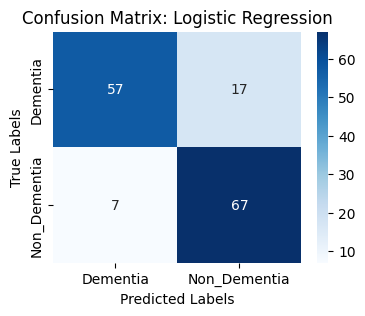

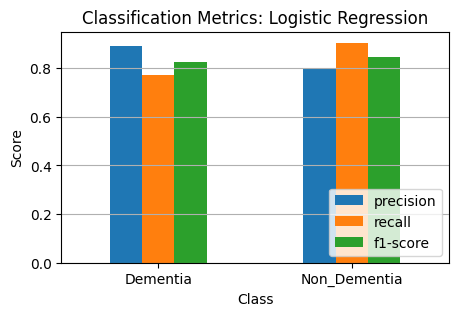

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load target variable
y = cleaned_df['class']  # Dementia or Non-Dementia

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts 'Dementia'/'Non-Dementia' to numeric

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize Logistic Regression model with regularization and class balancing
model = LogisticRegression(max_iter=1000, random_state=42, C=0.1, class_weight='balanced')
model.fit(X_train, y_train)

# Save the trained model for future use
model_path = r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Models\Logistic_Regression_Model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model, f)
print(f"Model saved to: {model_path}")

# Evaluate cross-validation accuracy
cv_scores = cross_val_score(model, X_tfidf, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Predict on the test data
y_pred = model.predict(X_test)

# Training accuracy
y_train_pred = model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")

# Testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred)
print(f"Testing Accuracy: {testing_accuracy:.2f}")

# Evaluate the model
print("Logistic Regression Classification Report:")
report = classification_report(y_test, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report).transpose())

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

print("Accuracy Score:", accuracy_score(y_test, y_pred))

# Visualize Confusion Matrix as Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Logistic Regression')
plt.show()

# Extract metrics for visualization
metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Visualize Precision, Recall, and F1-Score
metrics_df.plot(kind='bar', figsize=(5, 3))
plt.title('Classification Metrics: Logistic Regression')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()

Random Forest

Random Forest model saved to: C:\Users\mdnah\OneDrive\Desktop\TextClassification\Models\RandomForest_Model.pkl
Training Accuracy: 1.0
Testing Accuracy: 0.7297297297297297
Confusion Matrix:
[[69  5]
 [35 39]]


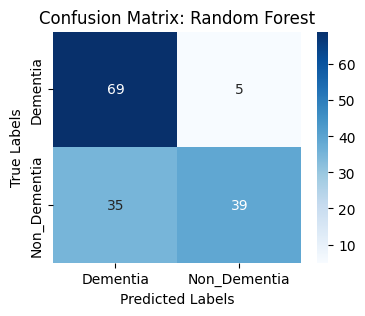

Random Forest Classification Report:
              precision    recall  f1-score   support

    Dementia       0.66      0.93      0.78        74
Non_Dementia       0.89      0.53      0.66        74

    accuracy                           0.73       148
   macro avg       0.77      0.73      0.72       148
weighted avg       0.77      0.73      0.72       148

Confusion Matrix:
[[69  5]
 [35 39]]
Accuracy Score: 0.7297297297297297


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
import pickle

# Load target variable
y = cleaned_df['class']  # Dementia or Non-Dementia

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

# Initialize Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=None,         # No limit on tree depth
    random_state=42,        # For reproducibility
    class_weight='balanced' # Handle class imbalance if needed
)

# Train the model on the training data
rf_model.fit(X_train, y_train)

# Save the trained model for future use
rf_model_path = r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Models\RandomForest_Model.pkl'
with open(rf_model_path, 'wb') as f:
    pickle.dump(rf_model, f)
print(f"Random Forest model saved to: {rf_model_path}")

# Predict on the test data
y_pred_rf = rf_model.predict(X_test)

# Predict on the training data for calculating training accuracy
y_train_pred = rf_model.predict(X_train)

# Calculate training accuracy
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy}")

# Calculate testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Testing Accuracy: {testing_accuracy}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize Confusion Matrix as Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix: Random Forest')
plt.show()

# Evaluate the model
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("Accuracy Score:", accuracy_score(y_test, y_pred_rf))


SVM

SVM model saved to: C:\Users\mdnah\OneDrive\Desktop\TextClassification\Models\SVM_Model.pkl
Cross-Validation Accuracy: 0.76 ± 0.03
Training Accuracy: 0.99
Testing Accuracy: 0.82
SVM Classification Report:
              precision    recall  f1-score     support
Dementia       0.850746  0.770270  0.808511   74.000000
Non_Dementia   0.790123  0.864865  0.825806   74.000000
accuracy       0.817568  0.817568  0.817568    0.817568
macro avg      0.820435  0.817568  0.817159  148.000000
weighted avg   0.820435  0.817568  0.817159  148.000000
Confusion Matrix:
[[57 17]
 [10 64]]
Accuracy score:  0.8175675675675675


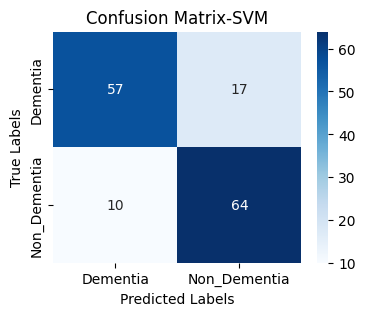

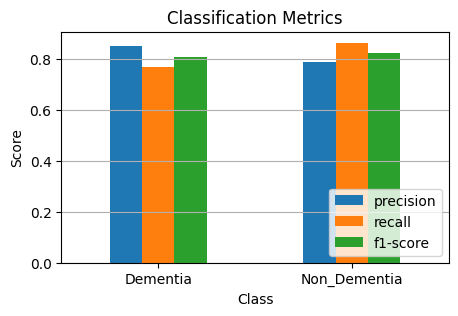

In [12]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Load target variable
y = cleaned_df['class']  # Dementia or Non-Dementia

# Encode target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)  # Converts 'Dementia'/'Non-Dementia' to numeric

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize and train SVM with linear kernel
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

# Save the trained SVM model for future use
svm_model_path = r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Models\SVM_Model.pkl'
with open(svm_model_path, 'wb') as f:
    pickle.dump(svm_model, f)
print(f"SVM model saved to: {svm_model_path}")

# Cross-Validation Accuracy
cv_scores = cross_val_score(svm_model, X_tfidf, y_encoded, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

# Training accuracy
y_train_pred = svm_model.predict(X_train)
training_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Training Accuracy: {training_accuracy:.2f}")

# Predict on the test data
y_pred_svm = svm_model.predict(X_test)

# Testing accuracy
testing_accuracy = accuracy_score(y_test, y_pred_svm)
print(f"Testing Accuracy: {testing_accuracy:.2f}")

# Evaluate the model
print("SVM Classification Report:")
report = classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_, output_dict=True)
print(pd.DataFrame(report).transpose())

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix:")
print(conf_matrix)

print("Accuracy score: ", accuracy_score(y_test, y_pred_svm))

# Visualize Confusion Matrix as Heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix-SVM')
plt.show()

# Extract metrics for visualization
metrics_df = pd.DataFrame(report).transpose().drop(['accuracy', 'macro avg', 'weighted avg'])
metrics_df = metrics_df[['precision', 'recall', 'f1-score']]

# Visualize Precision, Recall, and F1-Score
metrics_df.plot(kind='bar', figsize=(5, 3))
plt.title('Classification Metrics')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import History

Tokenizer and padding for LSTM

In [13]:
# 1. Load your data
sentences = cleaned_df['sentences'].values  # Using 'clean_text' as input
labels = cleaned_df['class'].values  # Target variable (dementia or non-dementia)

# 2. Label Encoding (converting 'dementia' and 'non-dementia' to 0 and 1)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # This will convert 'dementia' -> 1 and 'non-dementia' -> 0

# 3. Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)  # Fit tokenizer on the cleaned text
X_sequences = tokenizer.texts_to_sequences(sentences)  # Convert text to sequences of integers

print(X_sequences)

# Save the tokenizer
tokenizer_save_path = r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Features\LSTM_tokenizer.pkl'
with open(tokenizer_save_path, 'wb') as file:
    pickle.dump(tokenizer, file)
print(f"Tokenizer saved to: {tokenizer_save_path}")

# 4. Padding sequences
max_len = 13  # You can choose a max length based on your dataset (adjust as needed)
X_padded = pad_sequences(X_sequences, maxlen=max_len, padding='post')  # Pad sequences to have same length
print(X_padded)

[[7, 130, 131, 256, 204, 2], [7, 40, 734, 5, 11, 41, 2], [454, 322, 323, 132, 5, 60], [67, 735, 736, 132], [737, 738, 18, 739, 42], [1, 257, 258, 4, 79], [455, 456, 740, 13, 457], [1, 741, 324, 458, 325, 22, 107, 80], [205, 95, 18, 742, 151], [1, 38, 326, 60], [327, 22, 107, 80, 2, 38], [1, 4, 326, 152], [7, 458, 456, 34, 459], [55, 460, 259, 22, 743], [1, 744, 745, 327, 42], [7, 14, 325, 96, 461], [1, 746, 747, 18, 173, 25], [260, 462, 44, 35, 33], [748, 14, 463, 81, 133], [463, 464, 465, 44, 35, 33], [749, 465, 30, 3], [6, 258, 174, 82, 30, 3], [750, 466, 751, 175, 61, 467, 134], [176, 752, 753, 61, 4, 34], [754, 61, 755, 756, 757], [758, 462, 61, 759, 760, 34], [257, 328, 61, 761, 762, 107, 13, 2], [763, 468, 81, 15, 12, 6, 764], [765, 261, 469, 108, 766], [16, 206, 207, 262, 767, 768, 769, 262, 132], [109, 470, 455, 61, 770], [471, 329, 174, 108, 771], [135, 772, 177, 261, 61, 34], [177, 109, 470, 208, 773, 174, 209], [774, 472, 775, 261, 61, 473, 76], [110, 776, 777, 778, 30, 3], 

LSTM

Epoch 1/20


c:\Users\mdnah\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.5331 - loss: 1.6811 - val_accuracy: 0.5541 - val_loss: 1.4290
Epoch 2/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7491 - loss: 1.1561 - val_accuracy: 0.7432 - val_loss: 1.1600
Epoch 3/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9115 - loss: 0.6886 - val_accuracy: 0.8041 - val_loss: 0.9588
Epoch 4/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9732 - loss: 0.4213 - val_accuracy: 0.7973 - val_loss: 0.8236
Epoch 5/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9754 - loss: 0.3290 - val_accuracy: 0.7838 - val_loss: 0.7783
Epoch 6/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9808 - loss: 0.2541 - val_accuracy: 0.7973 - val_loss: 0.6857
Epoch 7/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9967 - loss: 0.1866 - val_accuracy: 0.8041 - val_loss: 0.6206
Epoch 8/20
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9983 - loss: 0.1569 - val_accuracy: 0.8378 - val_loss: 0.

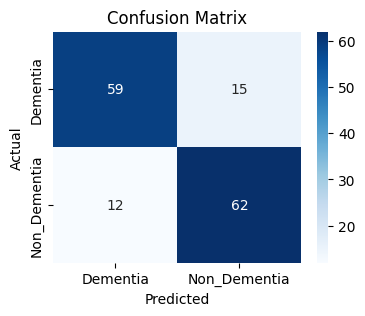

Classification Report:
              precision    recall  f1-score   support

    Dementia       0.83      0.80      0.81        74
Non_Dementia       0.81      0.84      0.82        74

    accuracy                           0.82       148
   macro avg       0.82      0.82      0.82       148
weighted avg       0.82      0.82      0.82       148

Accuracy Score: 0.8175675675675675


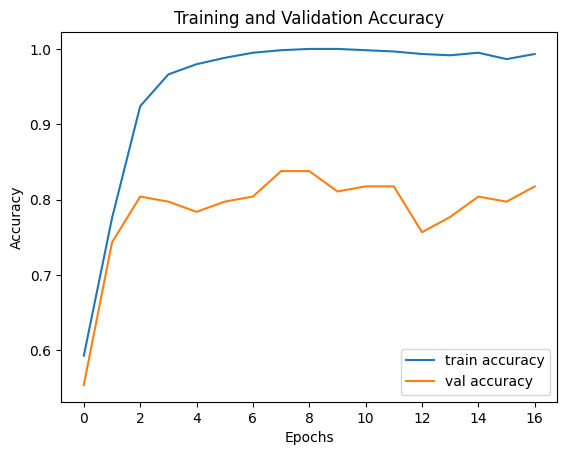

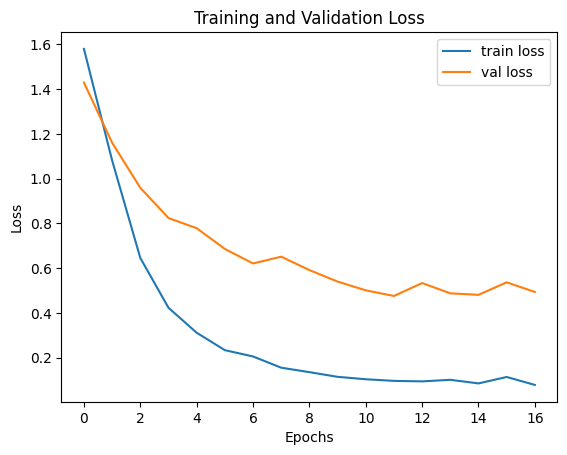

Model saved as 'Lstm_model.h5'


In [19]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Define the LSTM model with L2 Regularization and Batch Normalization
def create_lstm_model(vocab_size, max_len):
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(input_dim=vocab_size, output_dim=60, input_length=max_len))
    
    # LSTM layer with L2 regularization and Dropout
    model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
    
    # Batch Normalization
    model.add(BatchNormalization())
    
    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to reduce overfitting
    
    # Output layer (binary classification: dementia vs non-dementia)
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# 2. Prepare data (train-test split)
X_train, X_test, y_train, y_test = train_test_split(X_padded, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

# 3. Create the LSTM model
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size (adding 1 for padding token)
model = create_lstm_model(vocab_size, max_len)

# 4. Train the model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # More patience to allow more epochs
history = model.fit(X_train, y_train, epochs=20, batch_size=42, validation_data=(X_test, y_test), callbacks=[early_stop])

# 5. Evaluate the model on training and test data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

# Print training and testing accuracy
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# 6. Predictions and Evaluation Metrics
y_pred = (model.predict(X_test) > 0.5).astype("int32")  # Convert probabilities to binary class predictions

# Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Accuracy Score
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# 7. Plot Training and Testing Accuracy and Loss Graphs
# Training and Validation Accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training and Validation Loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# # 8. Cross-validation
# from sklearn.model_selection import KFold
# from keras.wrappers.scikit_learn import KerasClassifier

# # Create the KerasClassifier
# model_cv = KerasClassifier(build_fn=create_lstm_model, vocab_size=vocab_size, max_len=max_len, epochs=10, batch_size=32, verbose=0)

# # Cross-validation
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# cv_results = cross_val_score(model_cv, X_padded, labels_encoded, cv=kf, scoring='accuracy')

# # Print cross-validation results
# print(f"Cross-validation accuracy: {cv_results.mean():.4f} ± {cv_results.std():.4f}")

# 9. Save the model
model.save(r'C:\Users\mdnah\OneDrive\Desktop\TextClassification\Models\Lstm_model.h5')
print("Model saved as 'Lstm_model.h5'")


ML Model Testing

In [ ]:
import pickle
import numpy as np

# Load the Random Forest model
with open(r'C:\Users\AsifAK\Desktop\TextDementia\SVM_Model.pkl', 'rb') as f:
    rf_model = pickle.load(f)

# Load the TF-IDF vectorizer used during training
with open(r'C:\Users\AsifAK\Desktop\TextDementia\TFIDF_Vectorizer.pkl', 'rb') as f:
    tfidf_vectorizer = pickle.load(f)

# Input sentence to be tested
input_sentence = "শাড়ির কুচি কিভাবে দেয়"  # You can replace this with any other sentence 

# Transform the input sentence using the TF-IDF vectorizer
input_vector = tfidf_vectorizer.transform([input_sentence])

# Predict the class using the trained Random Forest model
y_pred_rf = rf_model.predict(input_vector)

print(y_pred_rf)

# Reverse the label encoding to get the original class labels
class_mapping = {0: "Dementia", 1: "Non-Dementia"}  # Adjust mapping if necessary

# Get the predicted class label
predicted_class = class_mapping[y_pred_rf[0]]

# Output the prediction
print(f"Predicted Class: {predicted_class}")


In [83]:
import numpy as np
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the trained LSTM model
model_path = r'C:\Users\AsifAK\Desktop\TextDementia\Lstm_model.h5'
lstm_model = load_model(model_path)
print(f"LSTM model loaded from: {model_path}")

# Load the tokenizer used during training
tokenizer_path = r'C:\Users\AsifAK\Desktop\TextDementia\LSTM_tokenizer.pkl'
with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)
print(f"Tokenizer loaded from: {tokenizer_path}")

# Input sentence to be tested
input_sentence = "বিকেলে কি খেয়েছি মনে করতে পারছি না"  # Replace with your sentence

# Tokenize and pad the input sentence
max_sequence_len = 13  # Replace with the max_sequence_len used during training
input_sequence = tokenizer.texts_to_sequences([input_sentence])  # Tokenize the sentence
input_padded = pad_sequences(input_sequence, maxlen=max_sequence_len, padding='pre')  # Pad the sequence
print(f"Tokenized and padded input: {input_padded}")

# Predict the class using the LSTM model
y_pred_prob = lstm_model.predict(input_padded)
y_pred_class = (y_pred_prob > 0.5).astype("int32")[0][0]  # Convert probability to class (0 or 1)

print(y_pred_prob[0][0])
print(y_pred_class)

# Reverse the label encoding to get the original class labels
class_mapping = {0: "Dementia", 1: "Non-Dementia"}  # Adjust mapping if necessary

# Get the predicted class label
predicted_class = class_mapping[y_pred_class]

# Output the prediction
print(f"Predicted Class: {predicted_class}")


LSTM model loaded from: C:\Users\AsifAK\Desktop\TextDementia\Lstm_model.h5
Tokenizer loaded from: C:\Users\AsifAK\Desktop\TextDementia\LSTM_tokenizer.pkl
Tokenized and padded input: [[  0   0   0   0   0   0  19  40 816   5  11  41   2]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
0.015702035
0
Predicted Class: Dementia


DL LSTM testing

In [84]:
import numpy as np
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 1. Load the trained LSTM model
model_path = r'C:\Users\AsifAK\Desktop\TextDementia\Lstm_model.h5'
lstm_model = load_model(model_path)
print(f"LSTM model loaded from: {model_path}")

# 2. Load the tokenizer used during training
tokenizer_path = r'C:\Users\AsifAK\Desktop\TextDementia\LSTM_tokenizer.pkl'
with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)
print(f"Tokenizer loaded from: {tokenizer_path}")

# 3. Input sentence to be tested
input_sentence = "বিকেলে কি খেয়েছি মনে করতে পারছি না"  # Replace with your Bangla sentence

# 4. Tokenize and pad the input sentence
max_sequence_len = 13  # Ensure this matches the training max sequence length
input_sequence = tokenizer.texts_to_sequences([input_sentence])  # Tokenize the sentence
input_padded = pad_sequences(input_sequence, maxlen=max_sequence_len, padding='pre')  # Pad the sequence
print(f"Tokenized Input: {input_sequence}")
print(f"Padded Input: {input_padded}")

# 5. Predict the class using the LSTM model
y_pred_prob = lstm_model.predict(input_padded)
print(f"Predicted Probability: {y_pred_prob[0][0]}")  # Raw probability output

# 6. Apply the threshold to classify
y_pred_class = 1 if y_pred_prob[0][0] > 0.3 else 0  # Adjust threshold if needed
print(f"Predicted Class Index: {y_pred_class}")

# 7. Reverse the label encoding to get the original class labels
class_mapping = {0: "Non-Dementia", 1: "Dementia"}  # Adjust mapping based on training
predicted_class = class_mapping[y_pred_class]

# 8. Output the prediction
print(f"Predicted Class: {predicted_class}")

# 9. Debugging Steps (Optional)
print("Debugging Details:")
print(f"Raw Model Output: {y_pred_prob}")
print(f"Final Prediction: {'Dementia' if y_pred_class == 1 else 'Non-Dementia'}")


LSTM model loaded from: C:\Users\AsifAK\Desktop\TextDementia\Lstm_model.h5
Tokenizer loaded from: C:\Users\AsifAK\Desktop\TextDementia\LSTM_tokenizer.pkl
Tokenized Input: [[19, 40, 816, 5, 11, 41, 2]]
Padded Input: [[  0   0   0   0   0   0  19  40 816   5  11  41   2]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step
Predicted Probability: 0.015702035278081894
Predicted Class Index: 0
Predicted Class: Non-Dementia
Debugging Details:
Raw Model Output: [[0.01570204]]
Final Prediction: Non-Dementia


Another Approach to see the both class prob

In [94]:
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define the LSTM model with L2 Regularization and Batch Normalization
def create_lstm_model(vocab_size, max_len):
    model = Sequential()
    
    # Embedding layer
    model.add(Embedding(input_dim=vocab_size, output_dim=60, input_length=max_len))
    
    # LSTM layer with L2 regularization and Dropout
    model.add(LSTM(units=128, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01)))
    
    # Batch Normalization
    model.add(BatchNormalization())
    
    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  # Dropout to reduce overfitting
    
    # Output layer with softmax for probabilities of both classes
    model.add(Dense(2, activation='softmax'))  # 2 outputs: "Dementia" and "Non-Dementia"
    
    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Prepare data (train-test split)
X_train, X_test, y_train, y_test = train_test_split(X_padded, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded)

# One-hot encode labels for softmax output
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Compute class weights
classes = np.array([0, 1])  # Ensure classes is a numpy array
class_weights = compute_class_weight('balanced', classes=classes, y=labels_encoded)
class_weights_dict = dict(enumerate(class_weights))
print(f"Class Weights: {class_weights_dict}")

# Create the LSTM model
vocab_size = len(tokenizer.word_index) + 1
model = create_lstm_model(vocab_size, max_len)

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), 
                    callbacks=[early_stop], class_weight=class_weights_dict)

# Evaluate the model
train_loss, train_accuracy = model.evaluate(X_train, y_train)
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Save the model
model.save(r'C:\Users\AsifAK\Desktop\TextDementia\test_Lstm_model.h5')
print("Model saved as 'Lstm_model.h5'")


Class Weights: {0: 1.0, 1: 1.0}
Epoch 1/20


c:\Users\AsifAK\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.5901 - loss: 1.6335 - val_accuracy: 0.6149 - val_loss: 1.3732
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.8031 - loss: 1.0634 - val_accuracy: 0.7973 - val_loss: 1.0868
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9265 - loss: 0.5663 - val_accuracy: 0.8041 - val_loss: 0.8430
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9576 - loss: 0.3687 - val_accuracy: 0.7635 - val_loss: 0.7544
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9743 - loss: 0.2807 - val_accuracy: 0.8108 - val_loss: 0.6550
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9890 - loss: 0.1922 - val_accuracy: 0.7905 - val_loss: 0.5874
Epoch 7/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9785 - loss: 0.2011 - val_accuracy: 0.7973 - val_loss: 0.5820
Epoch 8/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9912 - loss: 0.1365 - val_accuracy: 0.7770 - val_loss: 0.

Training Accuracy: 1.0000
Testing Accuracy: 0.8108
Model saved as 'Lstm_model.h5'


In [95]:
import numpy as np
from tensorflow.keras.models import load_model
import pickle
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the trained LSTM model
model_path = r'C:\Users\AsifAK\Desktop\TextDementia\test_Lstm_model.h5'
lstm_model = load_model(model_path)
print(f"LSTM model loaded from: {model_path}")

# Load the tokenizer used during training
tokenizer_path = r'C:\Users\AsifAK\Desktop\TextDementia\LSTM_tokenizer.pkl'
with open(tokenizer_path, 'rb') as file:
    tokenizer = pickle.load(file)
print(f"Tokenizer loaded from: {tokenizer_path}")

# Input sentence to be tested
input_sentence = "বিকেলে কি খেয়েছি মনে করতে পারছি না"  # Replace with your Bangla sentence

# Tokenize and pad the input sentence
max_sequence_len = 13
input_sequence = tokenizer.texts_to_sequences([input_sentence])
input_padded = pad_sequences(input_sequence, maxlen=max_sequence_len, padding='pre')
print(f"Tokenized Input: {input_sequence}")
print(f"Padded Input: {input_padded}")

# Predict the probabilities for both classes
y_pred_prob = lstm_model.predict(input_padded)
print(f"Predicted Probabilities: {y_pred_prob}")  # Output: Probabilities for both classes

# Extract probabilities for each class
prob_non_dementia = y_pred_prob[0][0]
prob_dementia = y_pred_prob[0][1]
print(f"Probability - Non-Dementia: {prob_non_dementia:.2f}")
print(f"Probability - Dementia: {prob_dementia:.2f}")

# Dynamic threshold adjustment
threshold = 0.5  # Adjust this threshold based on your dataset performance
predicted_class_index = 1 if prob_dementia > threshold else 0
class_mapping = {0: "Non-Dementia", 1: "Dementia"}
predicted_class = class_mapping[predicted_class_index]

# Output the prediction
print(f"Predicted Class: {predicted_class}")

# Debugging Details
print("Debugging Details:")
print(f"Raw Model Output: {y_pred_prob}")
print(f"Final Prediction: {predicted_class}")


LSTM model loaded from: C:\Users\AsifAK\Desktop\TextDementia\test_Lstm_model.h5
Tokenizer loaded from: C:\Users\AsifAK\Desktop\TextDementia\LSTM_tokenizer.pkl
Tokenized Input: [[19, 40, 816, 5, 11, 41, 2]]
Padded Input: [[  0   0   0   0   0   0  19  40 816   5  11  41   2]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Predicted Probabilities: [[0.9967706  0.00322939]]
Probability - Non-Dementia: 1.00
Probability - Dementia: 0.00
Predicted Class: Non-Dementia
Debugging Details:
Raw Model Output: [[0.9967706  0.00322939]]
Final Prediction: Non-Dementia
